## Important Libbraries

In [1]:
!pip install -U datasets huggingface_hub transformers[torch] evaluate peft bitsandbytes --quiet

In [3]:
from transformers import TrainingArguments, Trainer
import torch

2024-05-27 18:52:33.585959: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 18:52:33.586062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 18:52:33.704389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Pre-Processing and Loading

In [5]:
from datasets import load_dataset

dataset = load_dataset("nyu-mll/multi_nli")

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

In [6]:
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B", padding_side='left')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True

model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B",
    quantization_config=bnb_config,
    device_map="auto",
)

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

In [8]:
def predict(examples):
  tokenized = tokenizer(examples, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
  output = model.generate(**tokenized, pad_token_id=tokenizer.pad_token_id, max_new_tokens=1, temperature=0.01, tokenizer=tokenizer)
  texts = tokenizer.batch_decode(output)

  #print('\n'.join(texts))

  # TODO: Handel cases where model doesn't like to follow the instructions
  predictions = [int(text[-1]) if text[-1] in ['0', '1', '2'] else -1 for text in texts]

  return predictions

In [9]:
from tqdm import tqdm

In [10]:
with torch.no_grad():
  torch.cuda.empty_cache()

In [11]:
import evaluate

accuracy = evaluate.load("accuracy")

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [13]:
def generate_instructions(example, Premise, Hypothesis, Label):
    example['prompt'] = f'''Textual Entailment Task:
- If the *premise* logically implies the negation or opposite of the *hypothesis* (i.e., they are contradicting), then the *Sentence Label* should be equal to 2.
- If the *premise* does not provide enough information to determine if the *hypothesis* is true or false (i.e., they are neutral), then the *Sentence Label* should be equal to 1.
- If the *premise* logically implies or entails the *hypothesis*, then the *Sentence Label* should be equal to 0.
- The sentence label should end with 0, 1, or 2. (e.g. Sentence label = 1)
Look at the examples:
------------------
Premise: "{Premise.strip()}"
Hypothesis: "{Hypothesis.strip()}"
Sentence label = {Label}
------------------
Premise: "{example['premise'].strip()}"
Hypothesis: "{example['hypothesis'].strip()}"
Sentence label = '''

    return example

In [14]:
from datasets import Dataset

In [15]:
with torch.no_grad():
  torch.cuda.empty_cache()

In [ ]:
train_len = 128
train = dataset['train'][0:train_len]

max_accuracy = -1
max_train_Premise = ''
max_train_Hypothesis = ''
max_train_Label = -1

validation_len = 128 #round(len(dataset['validation_matched']) * 0.01)
validation = Dataset.from_dict(dataset['validation_matched'][0 : validation_len])

model.eval()
with torch.no_grad():
  for train_Premise, train_Hypothesis, train_Label in tqdm(zip(train['premise'], train['hypothesis'], train['label']), total=train_len):
    gen = lambda example: generate_instructions(example, train_Premise, train_Hypothesis, train_Label)
    validation = validation.map(gen)

    predictions = []
    references = []

    for i in (range(0, validation_len, 8)):
      examples = validation[i + 0:i + 8]
      prediction = predict(examples['prompt'])

      reference = examples['label']

      predictions += prediction
      references += reference

    accuracy_ = accuracy.compute(predictions=predictions, references=references)['accuracy']

    if max_accuracy < accuracy_:
      max_accuracy = accuracy_
      max_train_Premise = train_Premise
      max_train_Hypothesis = train_Hypothesis
      max_train_Label = train_Label

    print(accuracy_)

  0%|          | 0/128 [00:00<?, ?it/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  1%|          | 1/128 [00:30<1:04:21, 30.40s/it]

0.59375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  2%|▏         | 2/128 [01:05<1:09:25, 33.06s/it]

0.296875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  2%|▏         | 3/128 [01:35<1:05:53, 31.62s/it]

0.4453125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  3%|▎         | 4/128 [02:04<1:03:20, 30.65s/it]

0.5078125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  4%|▍         | 5/128 [02:35<1:03:18, 30.88s/it]

0.59375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  5%|▍         | 6/128 [03:06<1:03:02, 31.00s/it]

0.40625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  5%|▌         | 7/128 [03:39<1:03:47, 31.64s/it]

0.625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  6%|▋         | 8/128 [04:09<1:01:58, 30.99s/it]

0.40625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  7%|▋         | 9/128 [04:37<59:56, 30.22s/it]  

0.3984375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  8%|▊         | 10/128 [05:10<1:00:43, 30.88s/it]

0.5


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  9%|▊         | 11/128 [05:40<59:42, 30.62s/it]  

0.4296875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

  9%|▉         | 12/128 [06:08<57:59, 29.99s/it]

0.421875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 10%|█         | 13/128 [06:40<58:23, 30.47s/it]

0.6484375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 11%|█         | 14/128 [07:13<59:16, 31.20s/it]

0.625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 12%|█▏        | 15/128 [07:45<59:03, 31.36s/it]

0.515625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 12%|█▎        | 16/128 [08:13<57:00, 30.54s/it]

0.4375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 13%|█▎        | 17/128 [08:42<55:40, 30.10s/it]

0.453125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 14%|█▍        | 18/128 [09:12<55:08, 30.08s/it]

0.453125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 15%|█▍        | 19/128 [09:43<55:09, 30.37s/it]

0.46875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 16%|█▌        | 20/128 [10:14<54:31, 30.29s/it]

0.65625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 16%|█▋        | 21/128 [10:45<54:24, 30.51s/it]

0.4140625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 17%|█▋        | 22/128 [11:13<52:59, 29.99s/it]

0.4375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 18%|█▊        | 23/128 [11:45<53:12, 30.41s/it]

0.5


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 19%|█▉        | 24/128 [12:13<51:50, 29.91s/it]

0.46875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 20%|█▉        | 25/128 [12:42<50:53, 29.65s/it]

0.46875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 20%|██        | 26/128 [13:17<52:48, 31.06s/it]

0.59375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 21%|██        | 27/128 [13:49<53:01, 31.50s/it]

0.4921875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 22%|██▏       | 28/128 [14:18<51:15, 30.76s/it]

0.625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 23%|██▎       | 29/128 [14:53<52:47, 31.99s/it]

0.4765625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 23%|██▎       | 30/128 [15:22<50:47, 31.10s/it]

0.3984375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 24%|██▍       | 31/128 [15:55<51:10, 31.66s/it]

0.3359375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 25%|██▌       | 32/128 [16:27<50:41, 31.68s/it]

0.3515625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 26%|██▌       | 33/128 [17:01<51:20, 32.42s/it]

0.4609375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 27%|██▋       | 34/128 [17:30<49:03, 31.31s/it]

0.65625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 27%|██▋       | 35/128 [18:07<51:08, 33.00s/it]

0.5


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 28%|██▊       | 36/128 [18:42<51:28, 33.57s/it]

0.359375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 29%|██▉       | 37/128 [19:12<49:24, 32.58s/it]

0.484375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 30%|██▉       | 38/128 [19:44<48:32, 32.36s/it]

0.453125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 30%|███       | 39/128 [20:15<47:16, 31.87s/it]

0.453125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 31%|███▏      | 40/128 [20:44<45:32, 31.05s/it]

0.375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 32%|███▏      | 41/128 [21:15<45:18, 31.25s/it]

0.375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 33%|███▎      | 42/128 [21:50<46:22, 32.35s/it]

0.6015625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 34%|███▎      | 43/128 [22:22<45:28, 32.10s/it]

0.3828125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 34%|███▍      | 44/128 [22:51<43:39, 31.19s/it]

0.625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 35%|███▌      | 45/128 [23:20<42:08, 30.47s/it]

0.4375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 36%|███▌      | 46/128 [23:50<41:41, 30.50s/it]

0.375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 37%|███▋      | 47/128 [24:22<41:38, 30.84s/it]

0.5


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 38%|███▊      | 48/128 [24:53<41:08, 30.85s/it]

0.5078125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 38%|███▊      | 49/128 [25:22<39:48, 30.23s/it]

0.6484375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 39%|███▉      | 50/128 [25:54<40:11, 30.92s/it]

0.34375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 40%|███▉      | 51/128 [26:26<39:53, 31.09s/it]

0.375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 41%|████      | 52/128 [26:54<38:28, 30.37s/it]

0.484375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 41%|████▏     | 53/128 [27:23<37:24, 29.92s/it]

0.4140625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 42%|████▏     | 54/128 [27:55<37:36, 30.49s/it]

0.640625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 43%|████▎     | 55/128 [28:26<37:19, 30.68s/it]

0.578125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 44%|████▍     | 56/128 [28:55<36:11, 30.15s/it]

0.59375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 45%|████▍     | 57/128 [29:26<35:49, 30.28s/it]

0.4921875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 45%|████▌     | 58/128 [29:56<35:19, 30.28s/it]

0.5703125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 46%|████▌     | 59/128 [30:25<34:19, 29.85s/it]

0.421875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 47%|████▋     | 60/128 [30:53<33:25, 29.49s/it]

0.6171875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 48%|████▊     | 61/128 [31:28<34:31, 30.92s/it]

0.5390625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 48%|████▊     | 62/128 [31:58<33:46, 30.71s/it]

0.390625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 49%|████▉     | 63/128 [32:30<33:48, 31.20s/it]

0.4765625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 50%|█████     | 64/128 [33:00<32:55, 30.86s/it]

0.4296875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 51%|█████     | 65/128 [33:32<32:40, 31.12s/it]

0.640625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 52%|█████▏    | 66/128 [34:03<31:59, 30.96s/it]

0.5078125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 52%|█████▏    | 67/128 [34:39<33:10, 32.63s/it]

0.5078125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 53%|█████▎    | 68/128 [35:08<31:28, 31.47s/it]

0.421875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 54%|█████▍    | 69/128 [35:37<30:24, 30.92s/it]

0.4765625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 55%|█████▍    | 70/128 [36:07<29:22, 30.39s/it]

0.5


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 55%|█████▌    | 71/128 [36:37<28:51, 30.38s/it]

0.6171875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 56%|█████▋    | 72/128 [37:12<29:46, 31.91s/it]

0.609375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 57%|█████▋    | 73/128 [37:42<28:32, 31.14s/it]

0.46875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 58%|█████▊    | 74/128 [38:12<27:41, 30.78s/it]

0.4296875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 59%|█████▊    | 75/128 [38:41<26:47, 30.32s/it]

0.4296875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 59%|█████▉    | 76/128 [39:10<25:50, 29.82s/it]

0.4765625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 60%|██████    | 77/128 [39:41<25:40, 30.21s/it]

0.4609375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 61%|██████    | 78/128 [40:09<24:47, 29.75s/it]

0.65625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 62%|██████▏   | 79/128 [40:42<25:05, 30.73s/it]

0.3203125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 62%|██████▎   | 80/128 [41:13<24:39, 30.83s/it]

0.5859375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 63%|██████▎   | 81/128 [41:43<23:49, 30.41s/it]

0.46875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 64%|██████▍   | 82/128 [42:12<22:55, 29.90s/it]

0.4453125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 65%|██████▍   | 83/128 [42:43<22:47, 30.38s/it]

0.4921875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 66%|██████▌   | 84/128 [43:17<23:05, 31.50s/it]

0.328125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 66%|██████▋   | 85/128 [43:57<24:25, 34.09s/it]

0.671875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 67%|██████▋   | 86/128 [44:42<26:01, 37.17s/it]

0.3984375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 68%|██████▊   | 87/128 [45:14<24:28, 35.81s/it]

0.625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 69%|██████▉   | 88/128 [45:45<22:44, 34.12s/it]

0.3671875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 70%|██████▉   | 89/128 [46:16<21:34, 33.20s/it]

0.4375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 70%|███████   | 90/128 [46:47<20:44, 32.75s/it]

0.6640625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 71%|███████   | 91/128 [47:21<20:22, 33.04s/it]

0.5859375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 72%|███████▏  | 92/128 [47:50<19:08, 31.91s/it]

0.4921875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 73%|███████▎  | 93/128 [48:23<18:48, 32.26s/it]

0.453125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 73%|███████▎  | 94/128 [48:56<18:25, 32.50s/it]

0.3359375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 74%|███████▍  | 95/128 [49:28<17:41, 32.18s/it]

0.4296875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 75%|███████▌  | 96/128 [49:58<16:48, 31.51s/it]

0.4609375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 76%|███████▌  | 97/128 [50:28<16:08, 31.24s/it]

0.6328125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 77%|███████▋  | 98/128 [50:57<15:14, 30.50s/it]

0.5234375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 77%|███████▋  | 99/128 [51:26<14:25, 29.86s/it]

0.4453125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 78%|███████▊  | 100/128 [51:54<13:48, 29.58s/it]

0.5


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 79%|███████▉  | 101/128 [52:27<13:42, 30.46s/it]

0.515625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 80%|███████▉  | 102/128 [53:01<13:35, 31.38s/it]

0.3125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 80%|████████  | 103/128 [53:31<12:54, 30.99s/it]

0.484375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 81%|████████▏ | 104/128 [54:01<12:19, 30.83s/it]

0.6015625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 82%|████████▏ | 105/128 [54:31<11:45, 30.65s/it]

0.4140625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 83%|████████▎ | 106/128 [55:01<11:09, 30.42s/it]

0.625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 84%|████████▎ | 107/128 [55:33<10:47, 30.83s/it]

0.34375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 84%|████████▍ | 108/128 [56:05<10:21, 31.07s/it]

0.359375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 85%|████████▌ | 109/128 [56:36<09:50, 31.09s/it]

0.515625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 86%|████████▌ | 110/128 [57:07<09:20, 31.16s/it]

0.453125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 87%|████████▋ | 111/128 [57:38<08:49, 31.14s/it]

0.453125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 88%|████████▊ | 112/128 [58:10<08:21, 31.35s/it]

0.421875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 88%|████████▊ | 113/128 [58:38<07:35, 30.36s/it]

0.4765625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 89%|████████▉ | 114/128 [59:07<07:01, 30.09s/it]

0.4140625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 90%|████████▉ | 115/128 [59:37<06:28, 29.89s/it]

0.453125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 91%|█████████ | 116/128 [1:00:06<05:54, 29.56s/it]

0.3828125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 91%|█████████▏| 117/128 [1:00:36<05:26, 29.70s/it]

0.4609375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 92%|█████████▏| 118/128 [1:01:05<04:54, 29.50s/it]

0.4296875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 93%|█████████▎| 119/128 [1:01:34<04:24, 29.35s/it]

0.4375


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 94%|█████████▍| 120/128 [1:02:02<03:53, 29.15s/it]

0.421875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 95%|█████████▍| 121/128 [1:02:33<03:26, 29.47s/it]

0.5078125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 95%|█████████▌| 122/128 [1:03:05<03:02, 30.35s/it]

0.6015625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 96%|█████████▌| 123/128 [1:03:34<02:29, 29.96s/it]

0.4296875


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 97%|█████████▋| 124/128 [1:04:07<02:03, 30.85s/it]

0.3203125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 98%|█████████▊| 125/128 [1:04:36<01:30, 30.29s/it]

0.515625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 98%|█████████▊| 126/128 [1:05:06<01:00, 30.08s/it]

0.4453125


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

 99%|█████████▉| 127/128 [1:05:38<00:30, 30.83s/it]

0.3515625


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

100%|██████████| 128/128 [1:06:11<00:00, 31.03s/it]

0.5390625


In [17]:
max_accuracy

0.671875

In [18]:
max_train_Premise

"To be sure that any needlework item is the genuine article (as opposed to an inferior import or machine-made piece), look for a lead seal with an M, the emblem of IBTAM meaning it's been certified by the Instituto de Bordado, Tapecaras e Arte?\xadsanato da Madeira (Institute of Madeiran Embroidery, Tapestry, and Handicrafts), an official island organization that has a showroom/museum on Rua Visconde de Anadia, 44."

In [19]:
max_train_Hypothesis

'There is a seal to show authenticity in needlework items made in Italy.'

In [20]:
max_train_Label

1

In [21]:
gen = lambda example: generate_instructions(example, max_train_Premise, max_train_Hypothesis, max_train_Label)
dataset = dataset.map(gen)

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

In [22]:
predictions = []
references = []
model.eval()

dataset_len = round(len(dataset['validation_matched']) * 1.0)

with torch.no_grad():
  for i in tqdm(range(0, dataset_len, 8)):
    examples = dataset['validation_matched'][i + 0:i + 8]
    prediction = predict(examples['prompt'])

    reference = examples['label']

    predictions += prediction
    references += reference

100%|██████████| 1227/1227 [2:11:59<00:00,  6.45s/it] 


In [23]:
erroneous_indices = [i for i, p in enumerate(predictions) if p == -1]
print(len(erroneous_indices))
predictions_fixed = [p for i, p in enumerate(predictions) if not i in erroneous_indices]
references_fixed = [r for i, r in enumerate(references) if not i in erroneous_indices]

6


In [24]:
accuracy.compute(predictions=predictions_fixed, references=references_fixed)

{'accuracy': 0.6087266795799776}

In [25]:
matrix = confusion_matrix(y_true=references_fixed, y_pred=predictions_fixed, labels=[0, 1, 2])

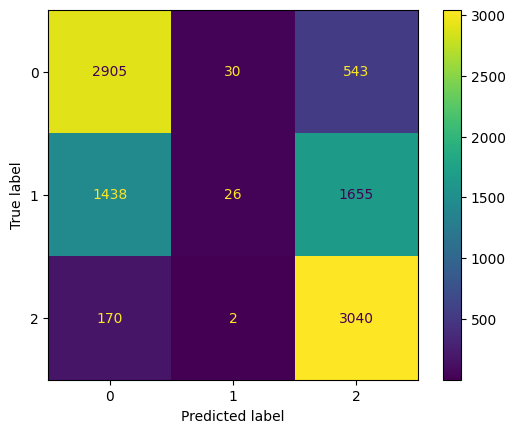

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()

In [27]:
predictions = []
references = []
model.eval()

dataset_len = round(len(dataset['validation_mismatched']) * 1.0)

with torch.no_grad():
  for i in tqdm(range(0, dataset_len, 8)):
    examples = dataset['validation_mismatched'][i + 0:i + 8]
    prediction = predict(examples['prompt'])

    reference = examples['label']

    predictions += prediction
    references += reference

100%|██████████| 1229/1229 [2:12:47<00:00,  6.48s/it] 


In [28]:
erroneous_indices = [i for i, p in enumerate(predictions) if p == -1]
print(len(erroneous_indices))
predictions_fixed = [p for i, p in enumerate(predictions) if not i in erroneous_indices]
references_fixed = [r for i, r in enumerate(references) if not i in erroneous_indices]

2


In [29]:
accuracy.compute(predictions=predictions_fixed, references=references_fixed)

{'accuracy': 0.6203458799593082}

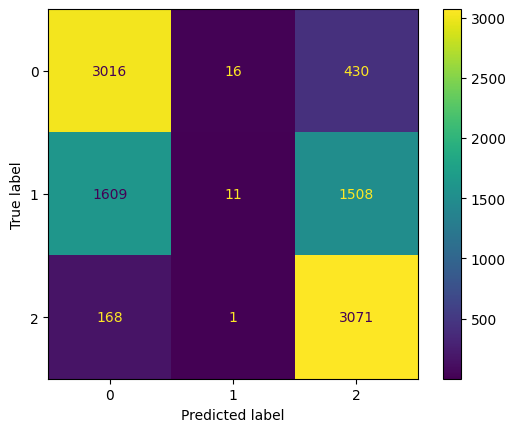

In [30]:
matrix = confusion_matrix(y_true=references_fixed, y_pred=predictions_fixed, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()